<a href="https://colab.research.google.com/github/Victor-F-Teodoro/signal-treatment/blob/main/Trait_don_audio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Installing the packages we'll need

!pip install spectrum
import math
from pylab import plot, log10, linspace, axis
from spectrum import *
from scipy.io import wavfile
from scipy import signal
from google.colab import files
import io 
import matplotlib.pyplot as plt
import numpy as np
from google.colab import drive
import pandas as pd
import ipywidgets as wg


In [2]:
# choosing the file we will analyse. The one from the results bellow is "croisement4.wav"

croisement = files.upload()


Saving croisement2.wav to croisement2.wav


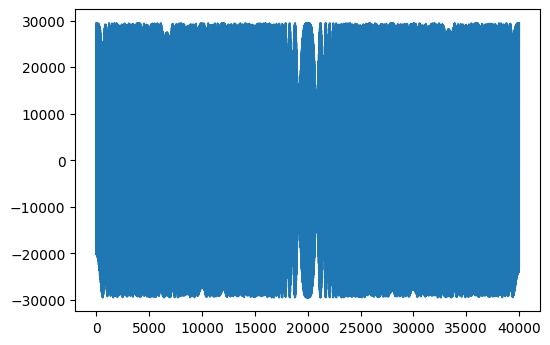

In [3]:
# Data extraction from provided file and visualization

samplerate, data  = wavfile.read(io.BytesIO(list(croisement.values())[0]))
fig = plt.figure(dpi=100, figsize=(6,4))
plt.plot(np.arange(len(data)), data)
plt.show()

In [4]:
# Ideal window size (samplerate * 40ms)
N = int(samplerate * 0.04)

# build all windows
windows = np.array([np.copy(data[i*N:i*N+N]) for i in range(len(data)//N)])


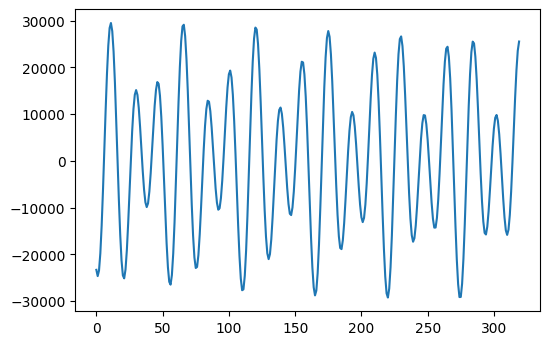

In [5]:
# Closer look of the signal
i = 19
fig = plt.figure(dpi=100, figsize=(6,4))
plt.plot(np.arange(len(windows[i])), windows[i])
plt.show()

In [7]:
## This part is only made to make visualization easier, the algo is still the same

def get_fft(window):
    len_window = len(window)
    channel_1 = np.zeros(2**16)
    channel_1[0:len_window] = window
    fourier = np.fft.fft(channel_1)
    freq_bins = np.fft.fftfreq(len(fourier), d=1/samplerate)
    return np.abs(fourier[0:len(fourier)//2]), freq_bins[:len(fourier)//2]


dic_left_peaks_fft = {}
dic_right_peaks_fft = {}

global flag_analysis_2
flag_analysis_2 = False

global jumpp 
jumpp = 0

#@title Window slicing
def window_vis(i=1):
    global jumpp
    global flag_analysis_2
    """
    function for displaying windows
    """ 
    print(i)
    fourier, bins = get_fft(windows[i])
    
    # Finding the peaks of the tranch
    max_list, _ = signal.find_peaks(fourier, height=750000, prominence=1, width=150)
    peaks = []
    for j in max_list:
      peaks.append(bins[j])
    

    # Detecting the crossings
    left_peak_bin = bins[np.min(max_list)]
    left_peak_int = fourier[np.min(max_list)]
    right_peak_bin = bins[np.max(max_list)]
    right_peak_int = fourier[np.max(max_list)]
    if len(peaks) == 2:
      jumpp = 0
      dic_left_peaks_fft[i] = (left_peak_bin, left_peak_int)
      dic_right_peaks_fft[i] = (right_peak_bin, right_peak_int)
    else:
        print('signals are crossing')
        jumpp += 1
        dic_left_peaks_fft[i] = dic_left_peaks_fft[i-jumpp]
        dic_right_peaks_fft[i] = dic_right_peaks_fft[i-jumpp]
        flag_analysis_2 = True
        print('f_a', flag_analysis_2)
    
    if flag_analysis_2 == True and len(peaks) == 2:
      if (dic_left_peaks_fft[i-1-jump][0]*0.80 <= dic_left_peaks_fft[i][1]) and (dic_left_peaks_fft[i][1] <= dic_left_peaks_fft[i-1-jump][1]*1.2):    
        print('A semi crossing hapenned')
      else:
        print('A crossing has hapenned')
      flag_analysis_2 = False
    
    # Plotting
    fig = plt.figure(dpi=80, figsize=(7, 5))
    plt.plot(bins[max_list], fourier[max_list], "x")
    plt.plot(bins, fourier)
    plt.xlim(0,1000)
    plt.show()


################################################################################
######################## Data presentation #####################################
################################################################################

button = wg.Button(
    description='Next',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click me',
    icon='check' # (FontAwesome names without the `fa-` prefix)
)
plot = wg.interactive(window_vis, i=(1, len(windows)))
def on_button_clicked(_):
    plot.children[0].value +=1
button.on_click(on_button_clicked)

display(plot)
display(button)

interactive(children=(IntSlider(value=1, description='i', max=125, min=1), Output()), _dom_classes=('widget-in…

Button(description='Next', icon='check', style=ButtonStyle(), tooltip='Click me')

In [8]:
## The algo is still the same of the previous cell. This code only makes
# visualisation easier

#@title Window slicing
def window_vis(i=1):
    # Finding the autoregression
    AR, rho, ref = arburg(windows[i], 7)
    # Getting the Power Spectrum Distribution
    PSD = arma2psd(AR, rho=rho, NFFT=4096)
    PSD = PSD[len(PSD):len(PSD)//2:-1]
    # Plotting the result
    x_array = linspace(0, 1*samplerate/2, len(PSD))
    plt.xlim(0,1000)
    plt.plot(x_array, 10*log10(abs(PSD)*2./(2.*pi)))
    plt.show()
    # Recording the peaks
    max2, _ = signal.find_peaks(PSD, height=0)
    peaks2 = []
    for j in max2:
      peaks2.append(x_array[j])
    


################################################################################
######################## Data presentation #####################################
################################################################################

button = wg.Button(
    description='Next',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click me',
    icon='check' # (FontAwesome names without the `fa-` prefix)
)
plot = wg.interactive(window_vis, i=(1, len(windows)))
def on_button_clicked(_):
    plot.children[0].value +=1
button.on_click(on_button_clicked)

display(plot)
display(button)

interactive(children=(IntSlider(value=1, description='i', max=125, min=1), Output()), _dom_classes=('widget-in…

Button(description='Next', icon='check', style=ButtonStyle(), tooltip='Click me')

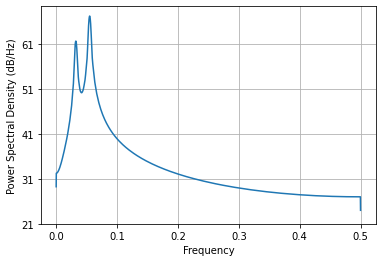

In [14]:
# Get FFT with WelchPeriodogram

from spectrum import WelchPeriodogram

lost_count = 0


psd = WelchPeriodogram(windows[10], 4096)
x_array = linspace(0, 1*samplerate/2, len(psd))
#max_list, _ = signal.find_peaks(psd[1], height=750000, prominence=1, width=150)
if len(max_list) < 2:
  lost_count += 1
plt.show()





1


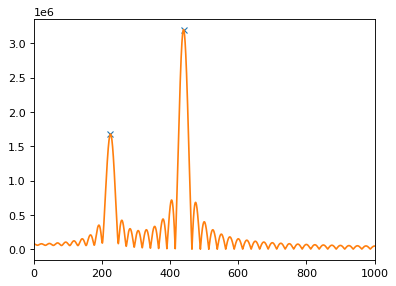

2


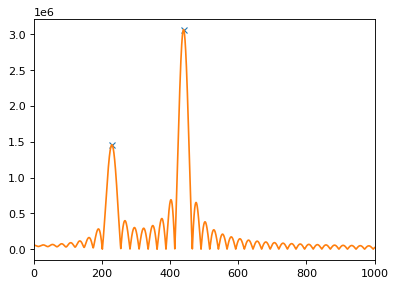

3


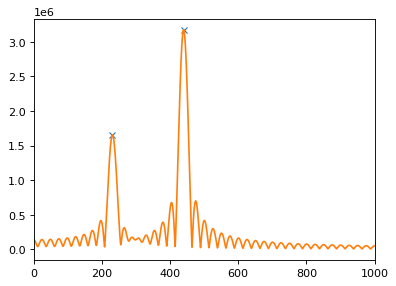

4


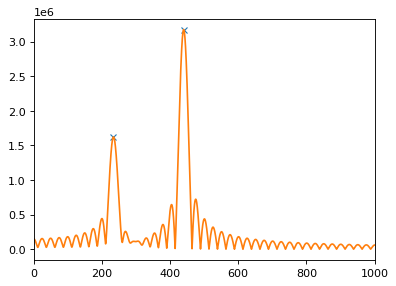

5


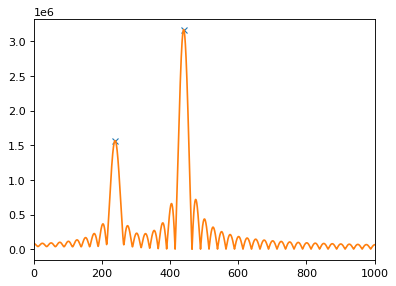

6


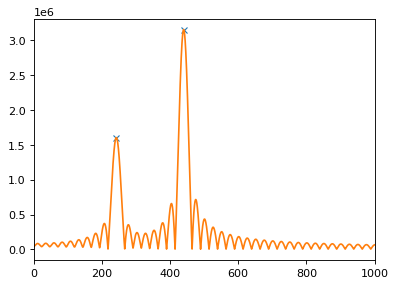

7


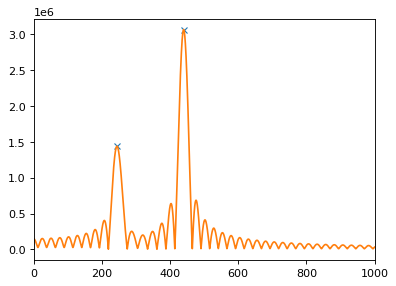

8


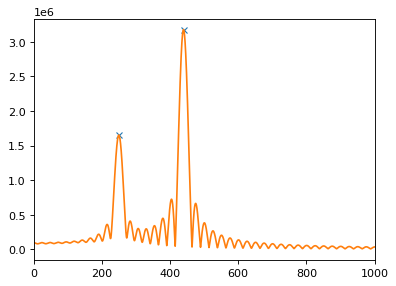

9


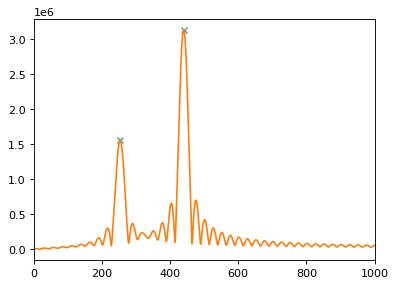

10


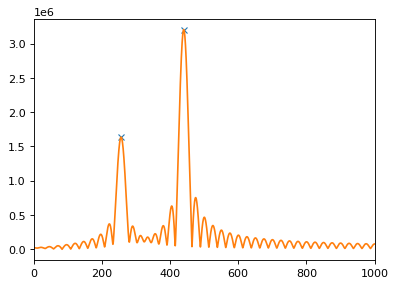

11


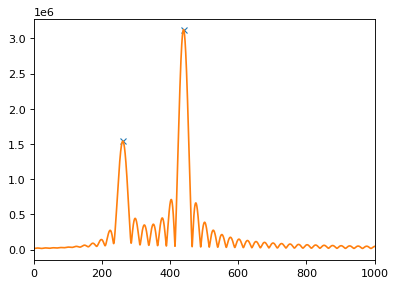

12


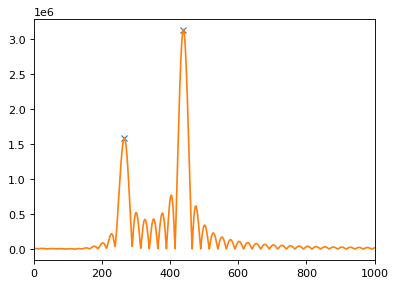

13


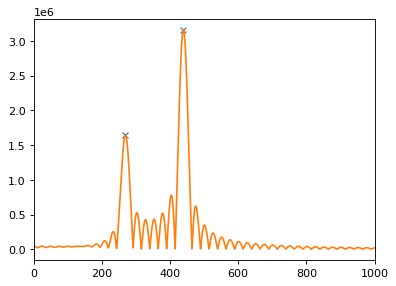

14


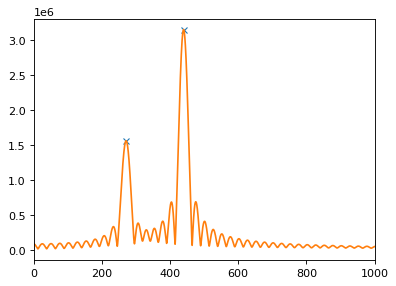

15


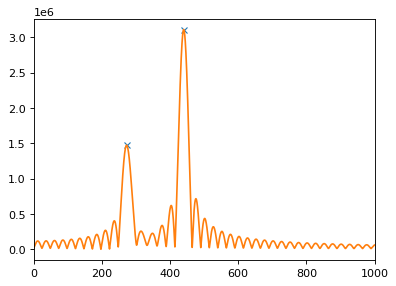

16


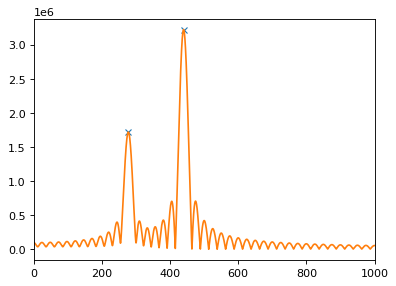

17


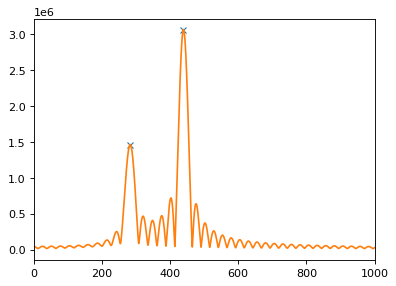

18


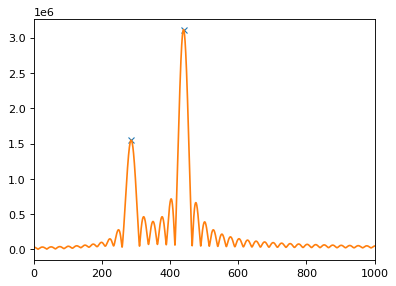

19


KeyboardInterrupt: ignored

In [6]:
# Finding the frequencies with the FFT


def get_fft(window):
    len_window = len(window)
    channel_1 = np.zeros(2**16)
    channel_1[0:len_window] = window
    fourier = np.fft.fft(channel_1)
    freq_bins = np.fft.fftfreq(len(fourier), d=1/samplerate)
    return np.abs(fourier[0:len(fourier)//2]), freq_bins[:len(fourier)//2]

dic_peaks_fft = {}
dic_left_peaks_fft = {}
dic_right_peaks_fft = {}
jump = 0
flag_analysis = False

# Aplying FFT on the tranches
for i in range(1, len(windows)):
  print(i)
  fourier, bins = get_fft(windows[i])
  
  # Finding the peaks of the tranch
  max_list, _ = signal.find_peaks(fourier, height=750000, prominence=1, width=150)
  peaks = []
  for j in max_list:
    peaks.append(bins[j])
  dic_peaks_fft[i] = peaks

  # Detecting the crossings
  left_peak_bin = bins[np.min(max_list)]
  left_peak_int = fourier[np.min(max_list)]
  right_peak_bin = bins[np.max(max_list)]
  right_peak_int = fourier[np.max(max_list)]
  # If we have two peaks, a crossing is not happening
  if len(peaks) == 2:
    jump = 0
    dic_left_peaks_fft[i] = (left_peak_bin, left_peak_int)
    dic_right_peaks_fft[i] = (right_peak_bin, right_peak_int)
  # If we don't, we print the message bellow, and start to increase the variable
  # jump, which will tell for how many trames the crossing passed
  else:
      print('signals are crossing')
      jump += 1
      dic_left_peaks_fft[i] = dic_left_peaks_fft[i-jump]
      dic_right_peaks_fft[i] = dic_right_peaks_fft[i-jump]
      flag_analysis = True
      print('f_a', flag_analysis)
  # When we have two peaks again, we compare the trame before the crossing
  # and the one right after. If they diverge more than 20%, a semi crossing
  # has happened (the signal crossed and then came back). If it is within
  # the 20% range, a normal crossing has taken place
  if flag_analysis == True and len(peaks) == 2:
    if (dic_left_peaks_fft[i-1-jump][0]*0.80 <= dic_left_peaks_fft[i][1]) and (dic_left_peaks_fft[i][1] <= dic_left_peaks_fft[i-1-jump][1]*1.2):    
      print('A semi crossing hapenned')
    else:
      print('A crossing has hapenned')
    flag_analysis = False
  
  # Plotting
  fig = plt.figure(dpi=80, figsize=(5.5, 4))
  plt.plot(bins[max_list], fourier[max_list], "x")
  plt.plot(bins, fourier)
  plt.xlim(0,1000)
  plt.show()

# Creating a DataFrame of the identified frequencies
df = pd.DataFrame(dic_peaks_fft.values(), dic_peaks_fft.keys())
print("Frequencies Found")
display(df.head())

# Displaying the number of tranches where we couldn't identify the two frequencies
num_lost = [i for i in dic_peaks_fft.values() if len(i) < 2]
print("\n\nA total of", len(num_lost), " tranches could not be analysed, corresponding to ", 
      round(len(num_lost)/len(dic_peaks_fft)*100, 2), " % of the total")



1


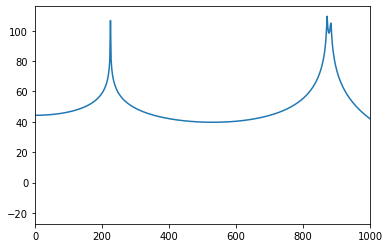

2


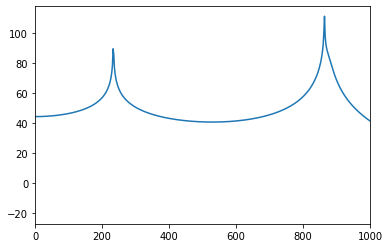

3


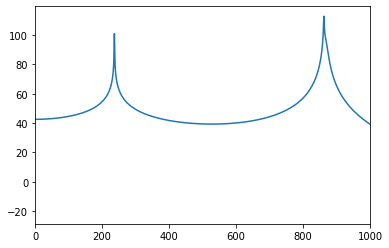

4


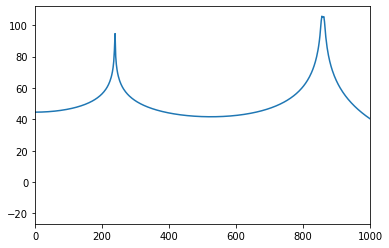

5


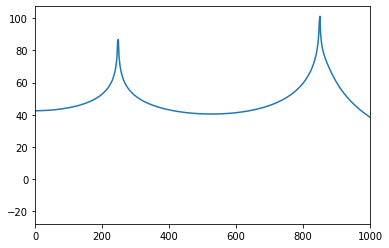

6


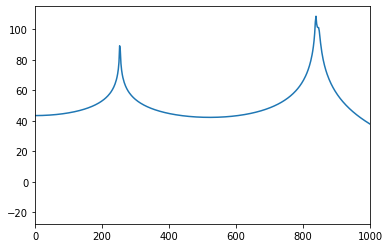

7


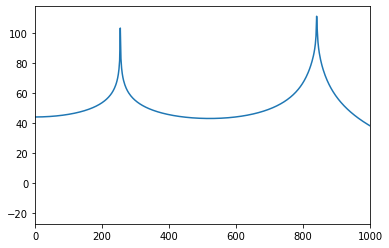

8


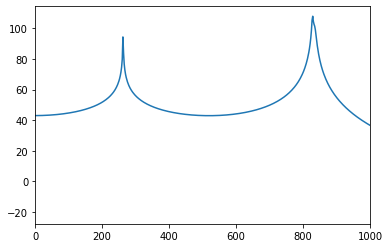

9


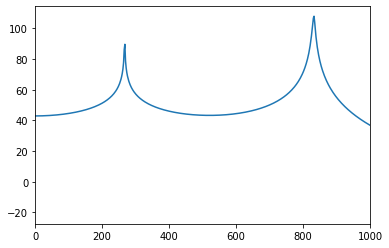

10


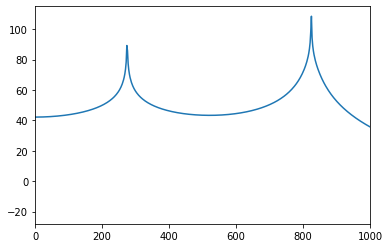

11


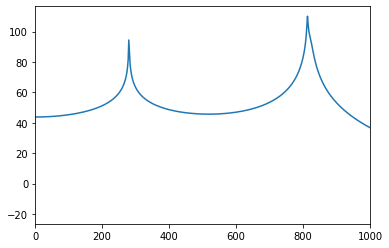

12


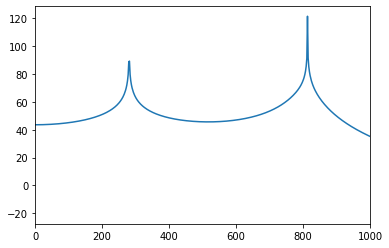

13


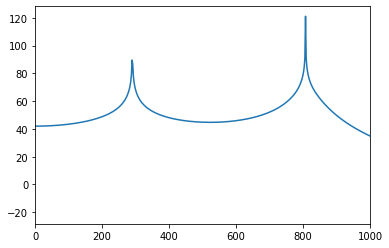

14


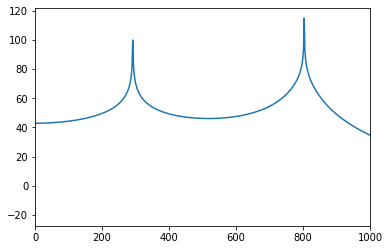

15


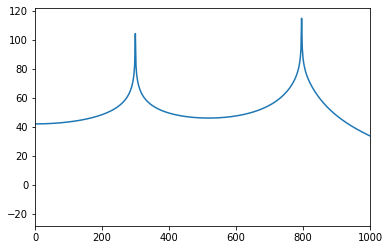

16


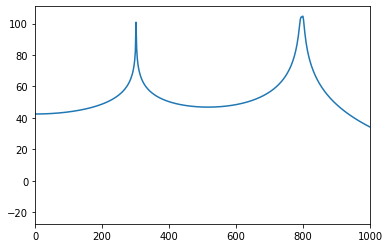

17


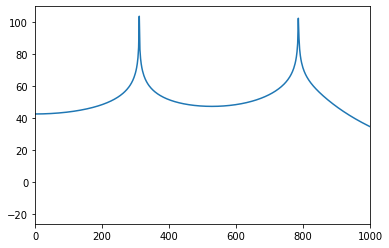

18


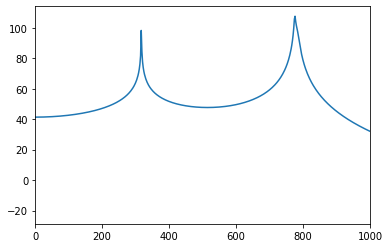

19


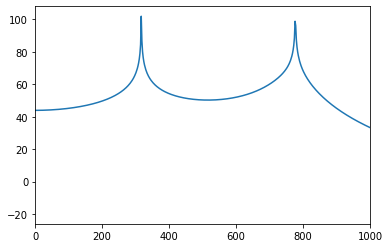

20


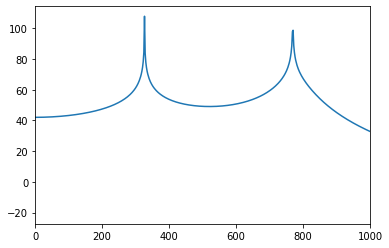

21


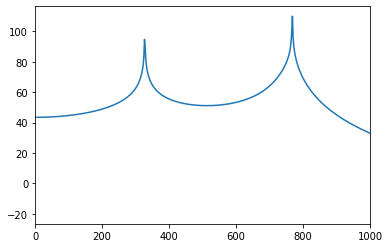

22


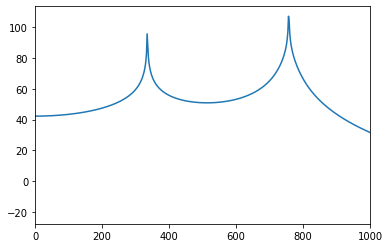

23


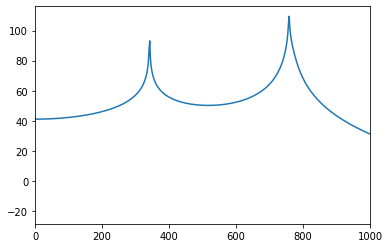

24


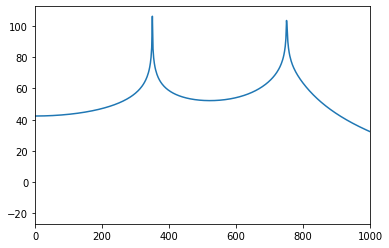

25


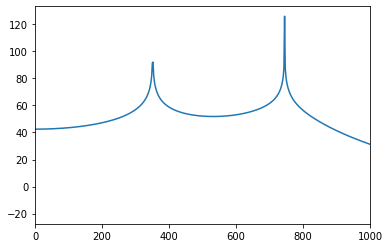

26


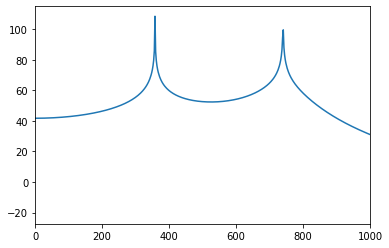

27


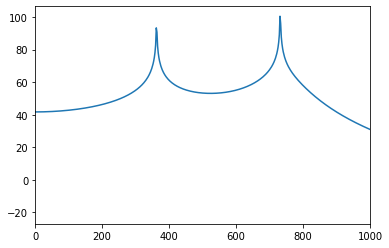

28


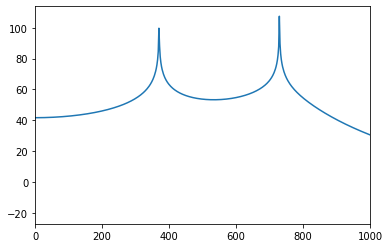

29


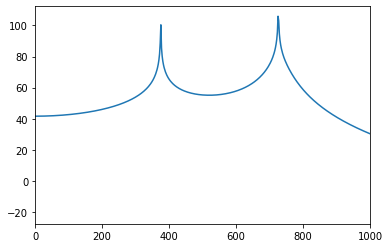

30


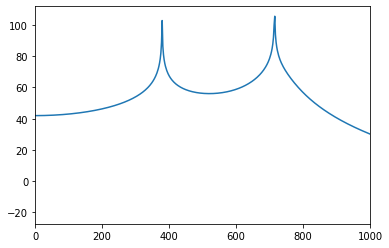

31


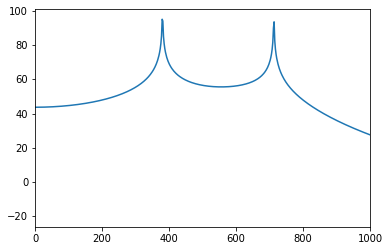

32


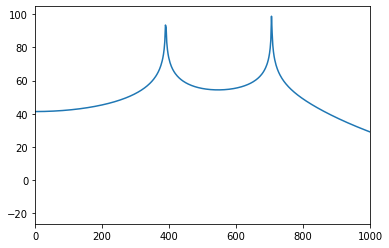

33


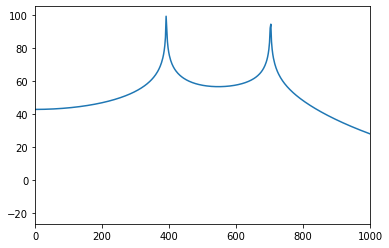

34


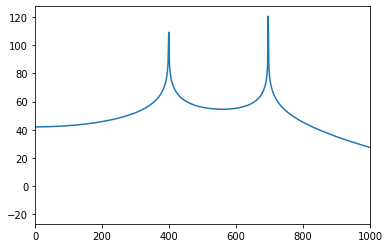

35


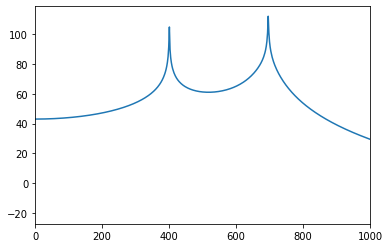

36


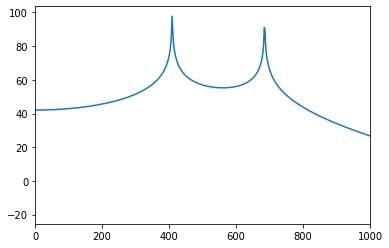

37


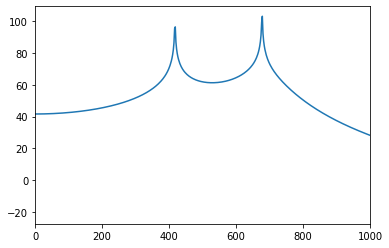

38


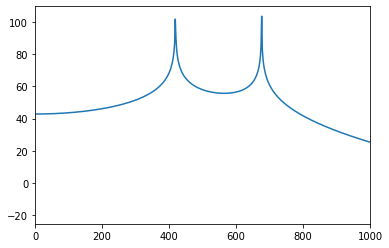

39


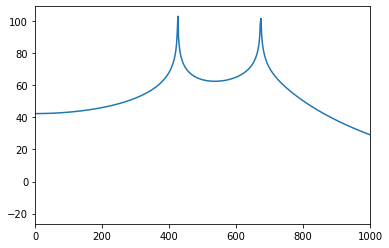

40


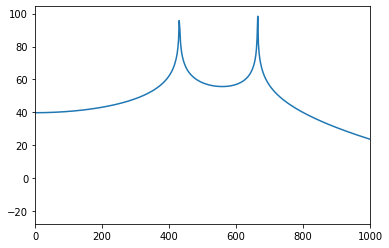

41


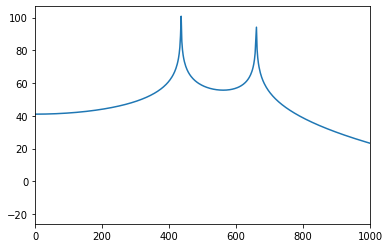

42


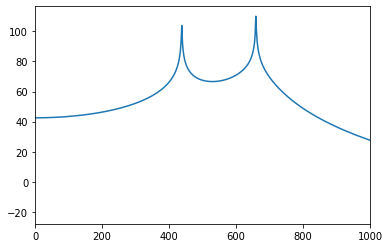

43


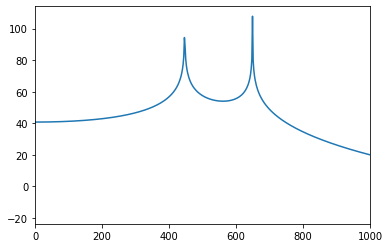

44


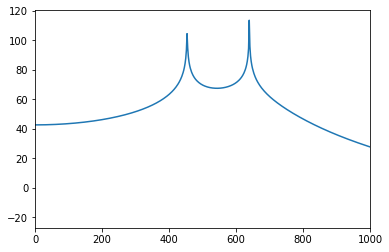

45


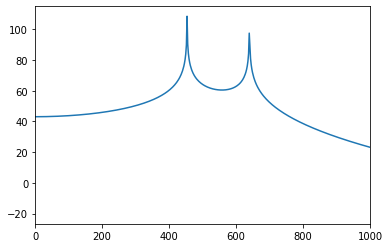

46


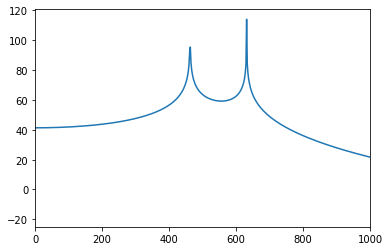

47


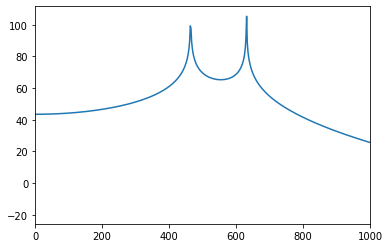

48


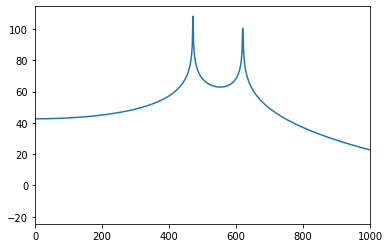

49


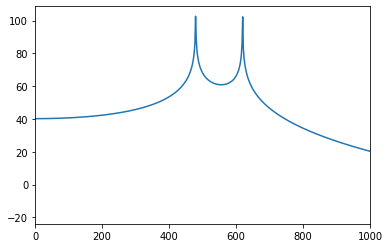

50


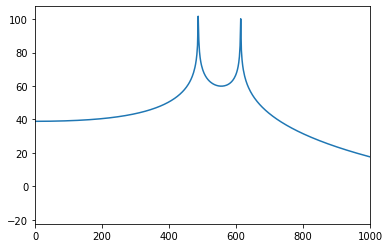

51


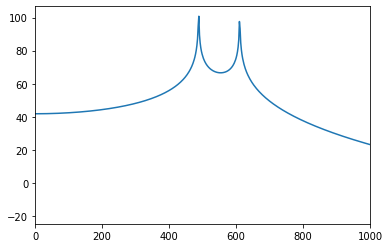

52


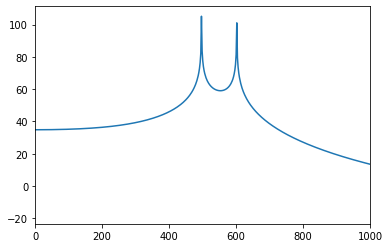

53


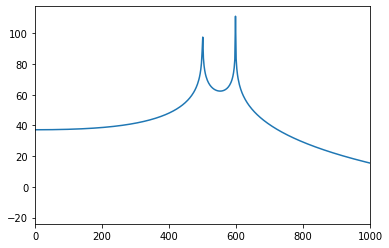

54


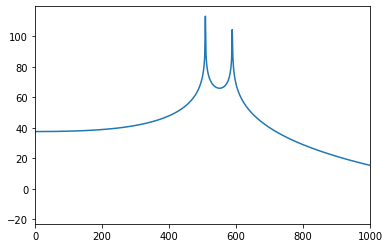

55


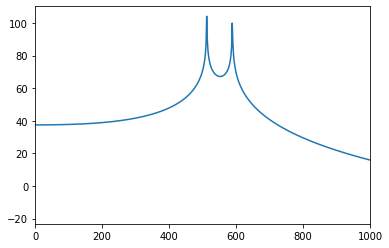

56


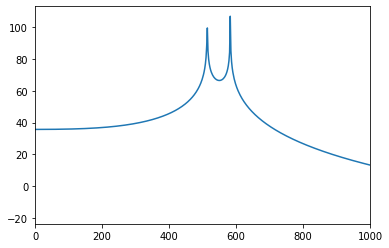

57


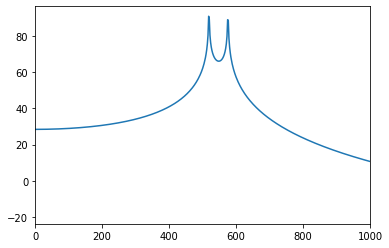

58


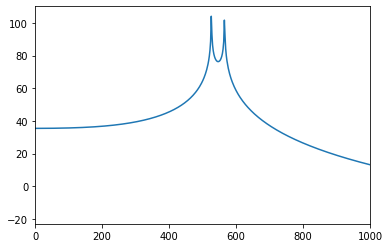

59


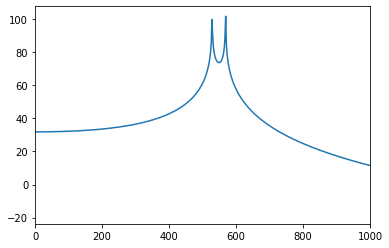

60


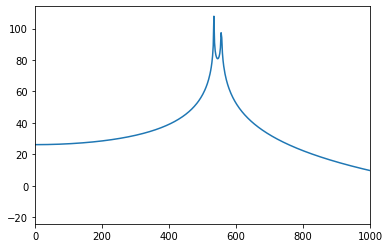

61


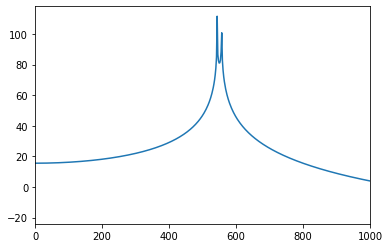

62


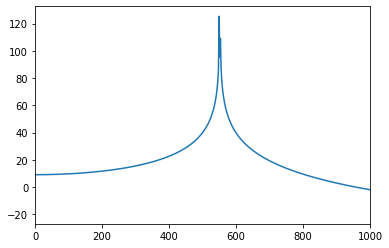

63


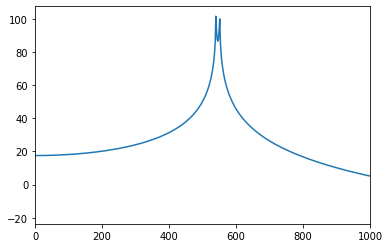

64


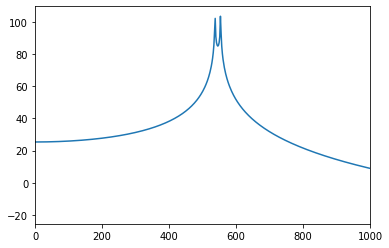

65


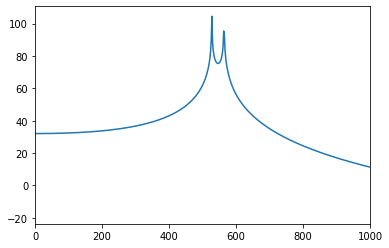

66


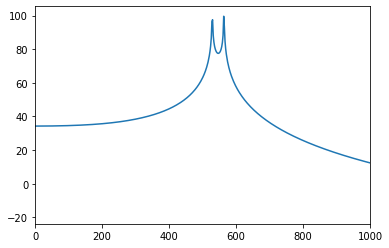

67


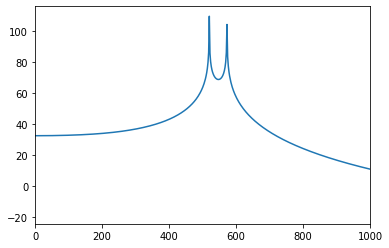

68


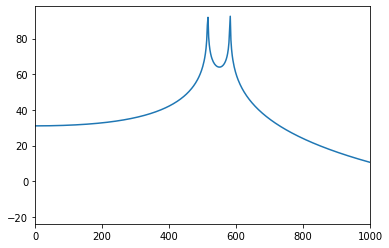

69


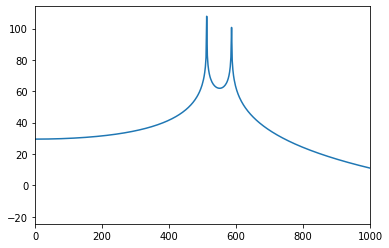

70


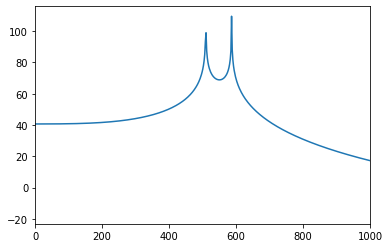

71


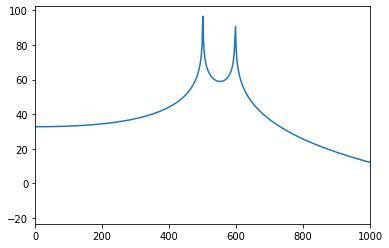

72


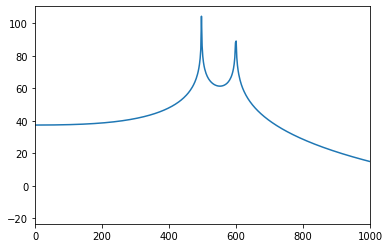

73


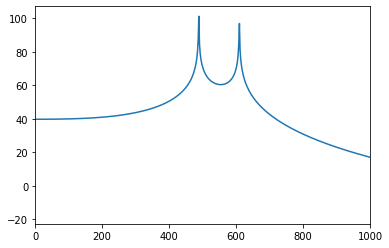

74


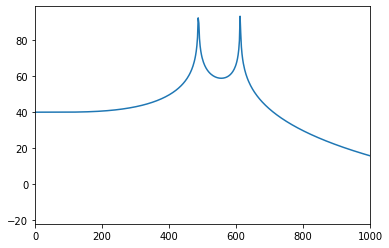

75


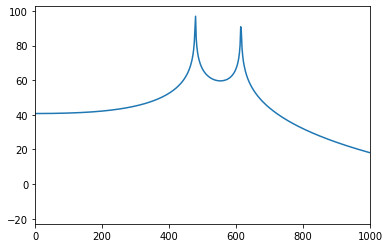

76


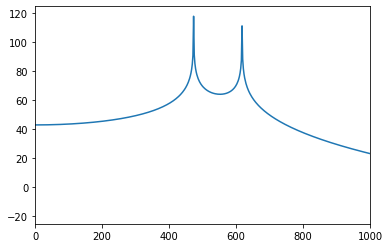

77


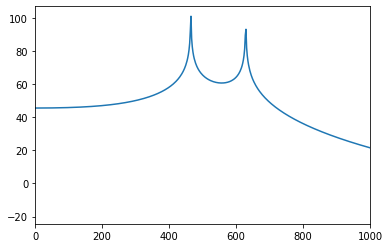

78


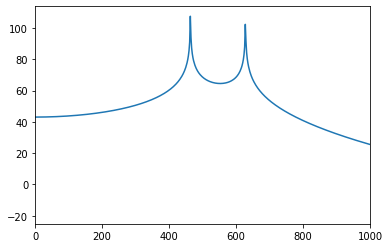

79


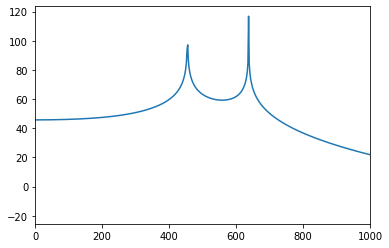

80


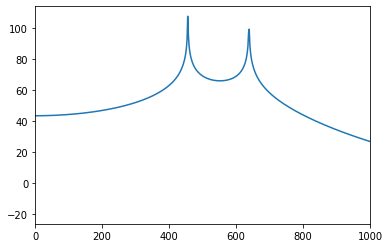

81


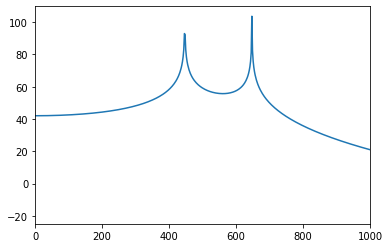

82


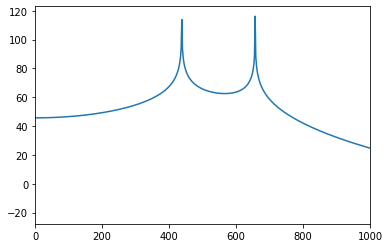

83


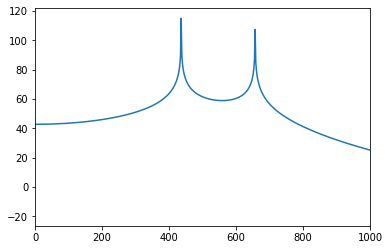

84


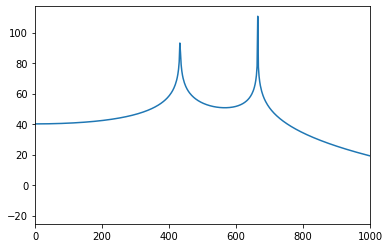

85


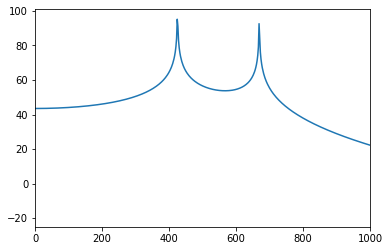

86


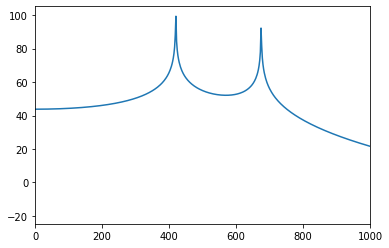

87


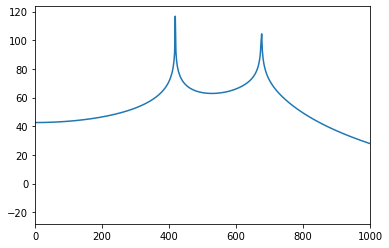

88


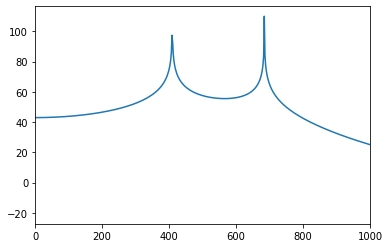

89


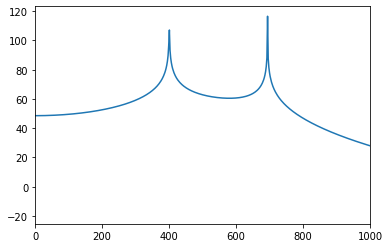

90


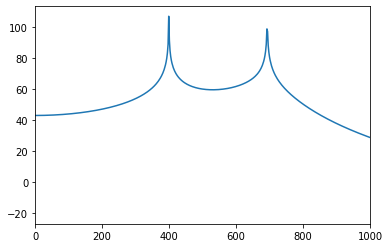

91


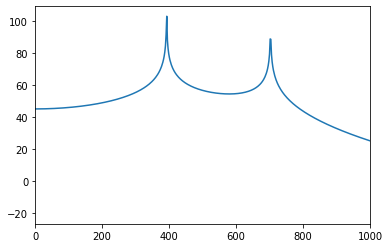

92


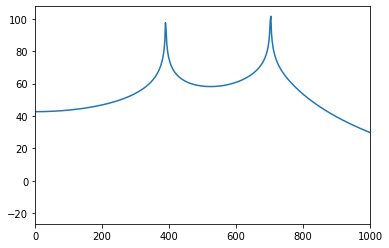

93


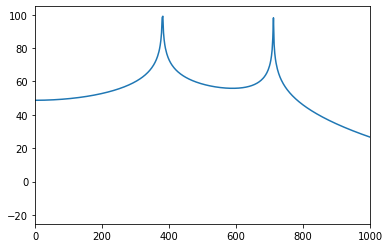

94


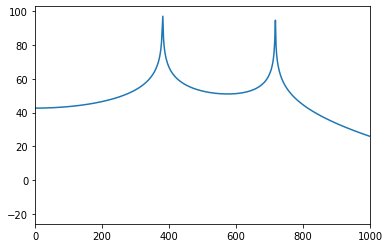

95


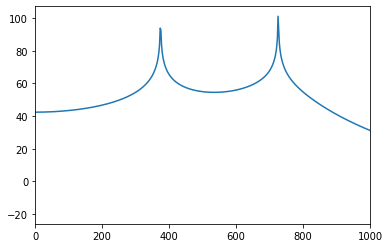

96


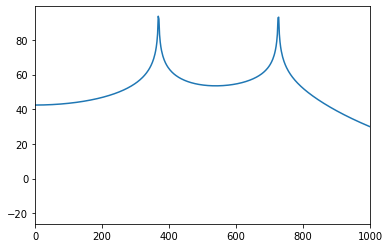

97


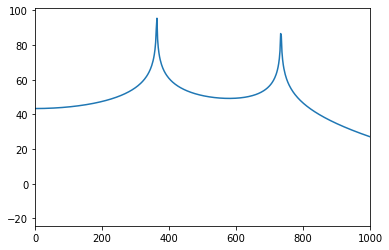

98


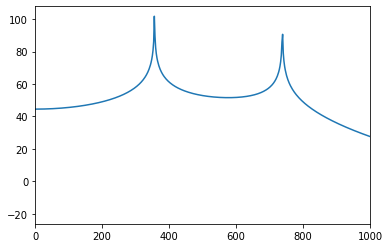

99


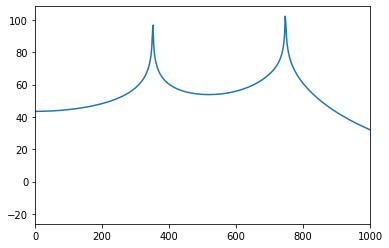

100


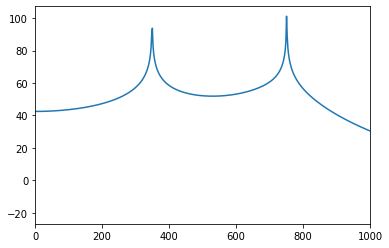

101


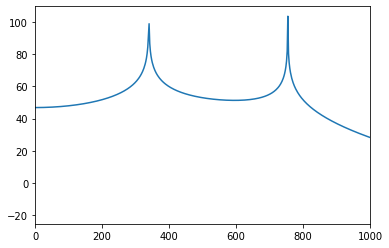

102


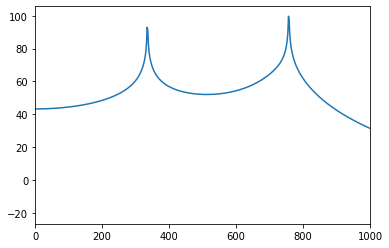

103


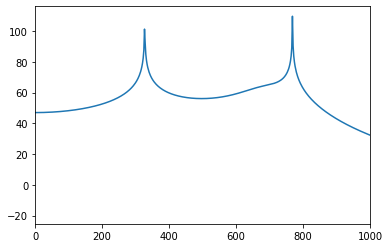

104


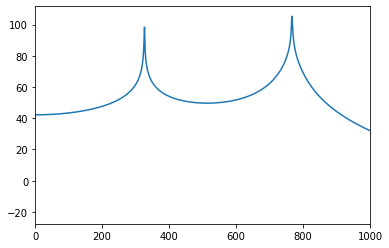

105


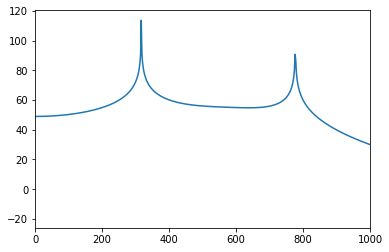

106


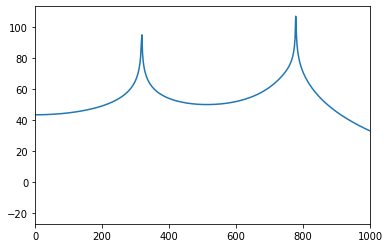

107


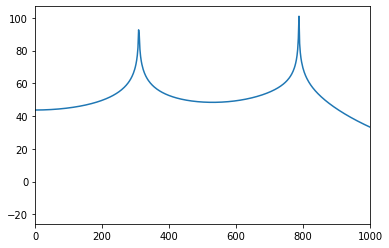

108


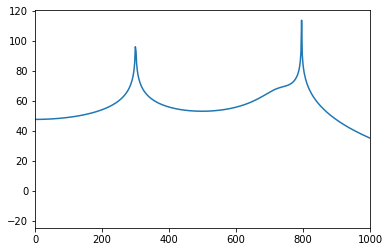

109


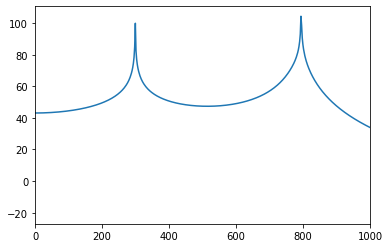

110


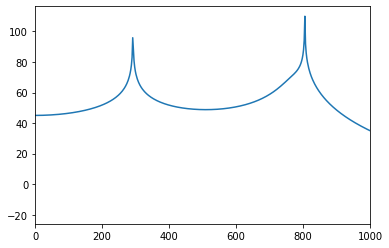

111


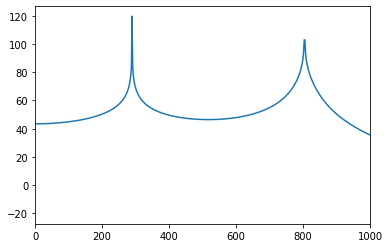

112


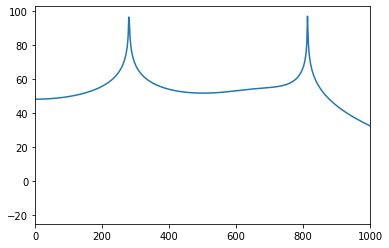

113


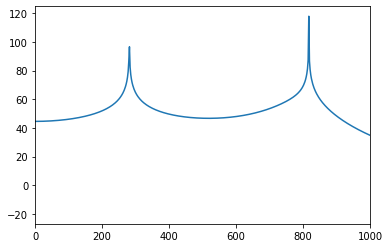

114


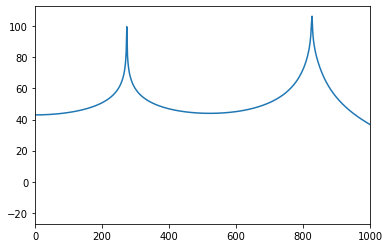

115


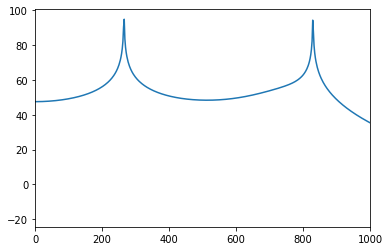

116


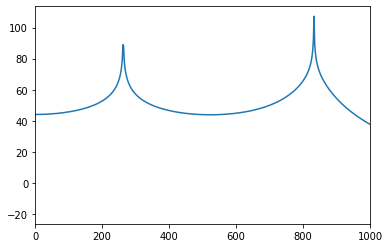

117


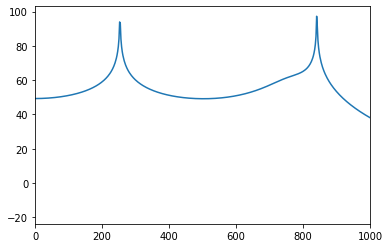

118


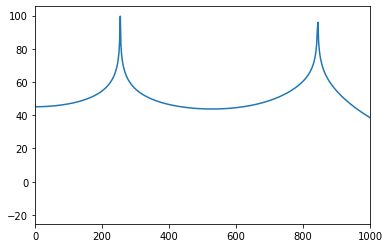

119


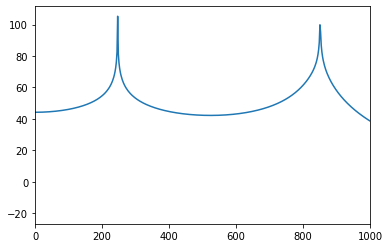

120


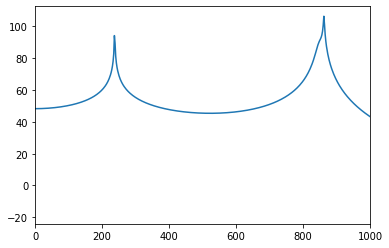

121


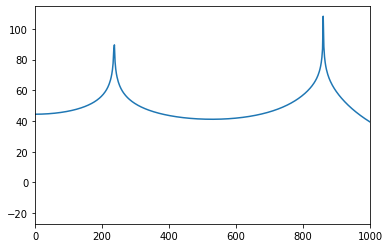

122


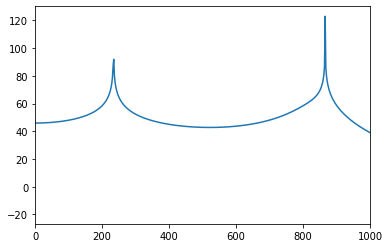

123


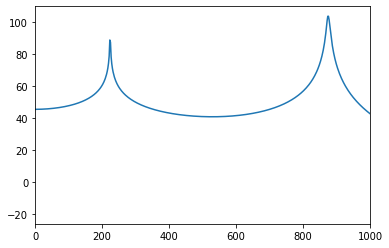

124


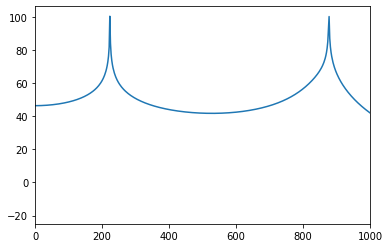

Frequencies Found


,0,1,2
1,224.828935,871.945259,883.675464
2,232.649071,864.125122,NaN
3,236.559140,862.170088,NaN
4,238.514174,856.304985,862.170088
5,248.289345,850.439883,NaN




A total of 0  tranches could not be analysed, corresponding to  0.0  % of the total


In [ ]:
# Aplying the Burg algortihm
dic_peaks_burg = {}

for i in range(1, len(windows)):
  print(i)
  # Finding the autoregression
  AR, rho, ref = arburg(windows[i], 7)
  # Getting the Power Spectrum Distribution
  PSD = arma2psd(AR, rho=rho, NFFT=4096)
  PSD = PSD[len(PSD):len(PSD)//2:-1]
  # Plotting the result
  x_array = linspace(0, 1*samplerate/2, len(PSD))
  plt.xlim(0,1000)
  plt.plot(x_array, 10*log10(abs(PSD)*2./(2.*pi)))
  plt.show()
  # Recording the peaks
  max2, _ = signal.find_peaks(PSD, height=0)
  peaks2 = []
  for j in max2:
    peaks2.append(x_array[j])
  dic_peaks_burg[i] = peaks2

# Creating a DataFrame of the identified frequencies
df = pd.DataFrame(dic_peaks_burg.values(), dic_peaks_burg.keys())
print("Frequencies Found")
display(df.head())

# Displaying the number of tranches where we couldn't identify the two frequencies
num_lost = [i for i in dic_peaks_burg.values() if len(i) < 2]
print("\n\nA total of", len(num_lost), " tranches could not be analysed, corresponding to ", 
      round(len(num_lost)/len(dic_peaks_burg)*100, 2), " % of the total")
